## Libraries

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pydub import AudioSegment
from pathlib import Path
from sklearn.preprocessing import StandardScaler

## Preprocessing

In [3]:
# 30s .wav files are split into 3s .wav files

input_folder = Path(r"..\dataset\30s_no_folders")
output_folder = Path(r"..\dataset\3s_no_folders")
output_folder.mkdir(exist_ok=True)

chunk_length_ms = 3 * 1000  # 3s

for wav_file in tqdm(sorted(input_folder.glob("*.wav"))):
    audio = AudioSegment.from_wav(wav_file)
    file_name = wav_file.stem 
    
    num_chunks = len(audio) // chunk_length_ms
    
    for i in range(num_chunks):
        start_ms = i * chunk_length_ms
        end_ms = start_ms + chunk_length_ms
        chunk = audio[start_ms:end_ms]
        
        chunk_name = f"{file_name}_{i:02d}.wav"
        chunk.export(output_folder / chunk_name, format="wav")

0it [00:00, ?it/s]

## Feature Extraction

In [4]:
def extract_features(filepath):
    # 22.05 kHz sampling
    y, sr = librosa.load(filepath, sr=22050)

    features = {}

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=15)
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(chroma.shape[0]):
        features[f'chroma_{i+1}_mean'] = np.mean(chroma[i])

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for i in range(contrast.shape[0]):
        features[f'contrast_{i+1}_mean'] = np.mean(contrast[i])

    # Other spectral features
    features['spec_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spec_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spec_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    return features


In [9]:
audio_dir = "../dataset/GZTAN_3s"
dataset = []

for filename in tqdm(os.listdir(audio_dir), desc="Processing audio files"):
    if filename.lower().endswith(".wav"):
        filepath = os.path.join(audio_dir, filename)
        
        # Extract genre from filename
        genre = filename.split('.')[0]
        
        try:
            features = extract_features(filepath)
            features['genre'] = genre
            
            dataset.append(features)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

df = pd.DataFrame(dataset)   
df.to_csv("../df/test2_features.csv", index=False)

df.columns   

Processing audio files:   0%|          | 0/9991 [00:00<?, ?it/s]

Index(['mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean',
       'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std',
       'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean',
       'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean',
       'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean',
       'mfcc_12_std', 'mfcc_13_mean', 'mfcc_13_std', 'mfcc_14_mean',
       'mfcc_14_std', 'mfcc_15_mean', 'mfcc_15_std', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean',
       'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean',
       'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean', 'contrast_1_mean',
       'contrast_2_mean', 'contrast_3_mean', 'contrast_4_mean',
       'contrast_5_mean', 'contrast_6_mean', 'contrast_7_mean',
       'spec_centroid_mean', 'spec_bandwidth_mean', 'spec_rolloff_mean',
       'zcr_mean', 'rms_mean', 'tempo', 'genre'],
      

In [3]:
df = pd.read_csv("../df/test2_features.csv")

## Data Visualization

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

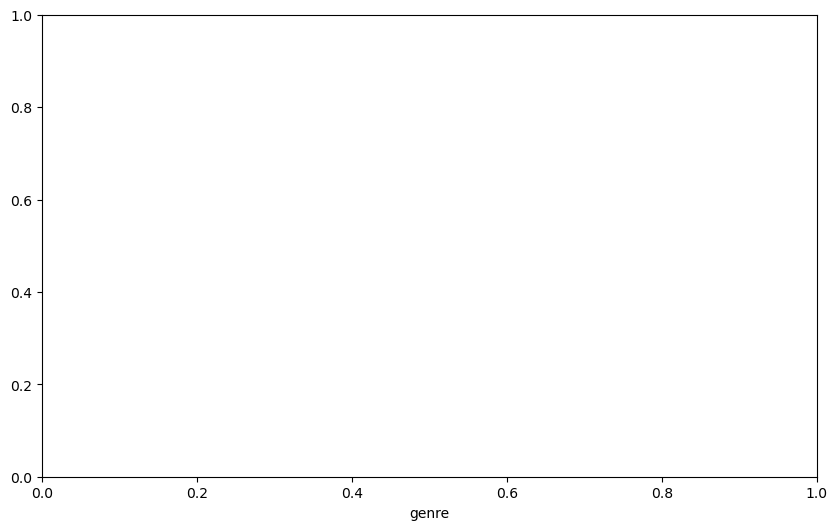

In [4]:
df.boxplot(column = 'tempo',
                by = 'genre', 
                figsize = (10, 6))
plt.show()

In [ ]:
# Not working

df.plot(x = 'tempo', 
             y = 'zcr_mean', 
             kind = 'scatter', 
             c = 'genre',
             colormap = 'viridis',
             colorbar = False, 
             figsize = (6, 6),
             title = 'genre scatter plot')

## Data Normalization

In [7]:
# Normaliza numerical features

X = df.drop(columns=['genre'])
y = df['genre']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(X_scaled_df.head())  
print(y.head()) 

   mfcc_1_mean  mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  \
0     0.251696    0.057316     0.701562   -0.768425    -0.563639    0.146514   
1     0.186297   -0.169232     0.623140   -0.935233    -0.450080   -0.424005   
2     0.123888    0.618872     0.404097   -0.825311    -0.200708   -0.628810   
3     0.258205    0.062810     0.890124   -0.556086    -0.358629   -1.135745   
4     0.372322   -0.128208     0.968042   -0.971117    -0.411687   -0.733823   

   mfcc_4_mean  mfcc_4_std  mfcc_5_mean  mfcc_5_std  ...  contrast_4_mean  \
0     0.235224    0.144877    -0.291490    0.261567  ...         0.017477   
1     0.726117   -0.189899    -0.684559    0.131225  ...        -0.147482   
2     0.725154   -0.100641     0.115489   -0.051961  ...        -0.439156   
3     0.131400    0.252303    -0.813254    0.139367  ...        -0.369386   
4     0.156281   -0.513815    -0.893212   -0.320715  ...        -0.261606   

   contrast_5_mean  contrast_6_mean  contrast_7_mean  sp

In [8]:
df = X_scaled_df.copy()
df['genre'] = y.values

# Save to CSV
df.to_csv("../df/test2_normalized_features.csv", index=False)

## Feature selection

In [53]:
feature_cols = df.columns.drop('genre') if 'genre' in df.columns else df.columns

# Correlation matrix between "mean" columns
mean_cols = [col for col in feature_cols if 'mean' in col]
df_mean = df[mean_cols]
corr_mean = df_mean.corr()
corr_mean_lower = corr_mean.where(np.tril(np.ones(corr_mean.shape), k=0).astype(bool))

# Correlation matrix between "std" columns
std_cols = [col for col in feature_cols if 'std' in col]
df_std = df[std_cols]
corr_std = df_std.corr()
corr_std_lower = corr_std.where(np.tril(np.ones(corr_std.shape), k=0).astype(bool))

### "mean" features

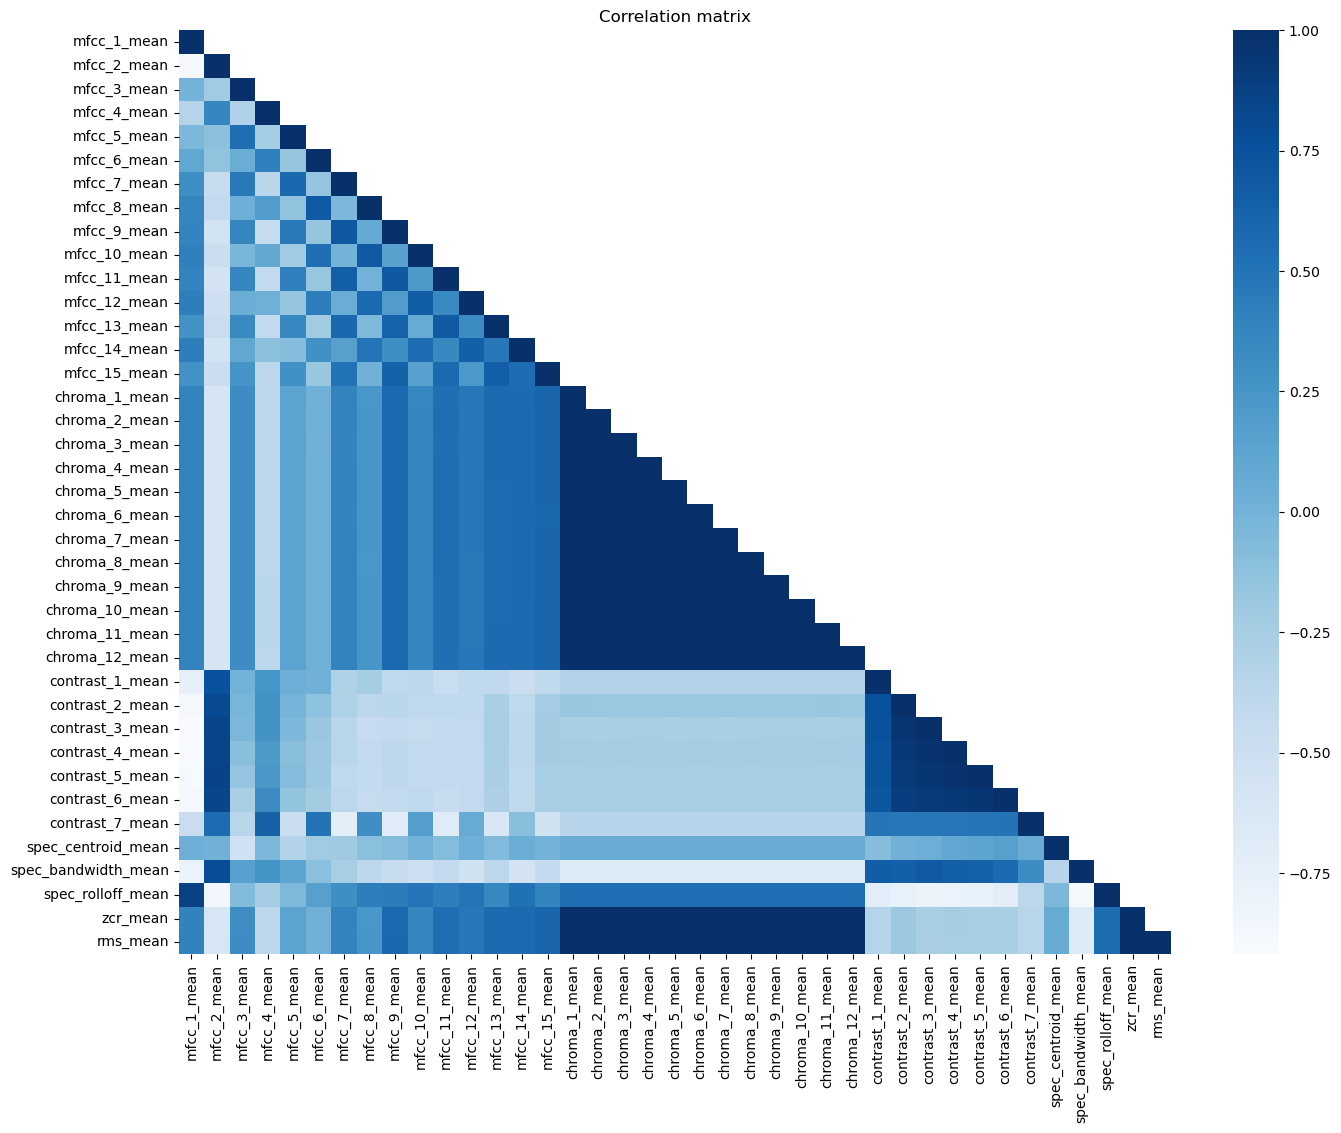

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr_mean_lower, cmap='Blues', annot=False)
plt.title("Correlation matrix")
plt.show()

In [55]:
# "mean" features pairs with high correlation
threshold = 0.98

high_corr_pairs = corr_mean_lower.stack()
high_corr_pairs = high_corr_pairs[(high_corr_pairs > threshold) & (high_corr_pairs < 1.0)]
high_corr_pairs = high_corr_pairs.sort_values(ascending=False)

pd.set_option('display.max_rows', None)
print(high_corr_pairs.reset_index().rename(columns={0:'correlation'}))

           level_0         level_1  correlation
0         rms_mean        zcr_mean     0.999909
1         zcr_mean   chroma_7_mean     0.999310
2         zcr_mean   chroma_2_mean     0.999279
3         rms_mean   chroma_7_mean     0.999251
4    chroma_8_mean   chroma_7_mean     0.999247
5         rms_mean   chroma_2_mean     0.999209
6         zcr_mean   chroma_9_mean     0.999203
7   chroma_10_mean   chroma_9_mean     0.999197
8         zcr_mean   chroma_4_mean     0.999194
9         zcr_mean  chroma_12_mean     0.999188
10   chroma_7_mean   chroma_6_mean     0.999177
11        zcr_mean   chroma_5_mean     0.999173
12   chroma_9_mean   chroma_8_mean     0.999156
13   chroma_2_mean   chroma_1_mean     0.999154
14  chroma_12_mean  chroma_11_mean     0.999149
15        rms_mean   chroma_9_mean     0.999138
16        rms_mean   chroma_4_mean     0.999131
17   chroma_4_mean   chroma_3_mean     0.999128
18        zcr_mean  chroma_10_mean     0.999121
19   chroma_5_mean   chroma_4_mean     0

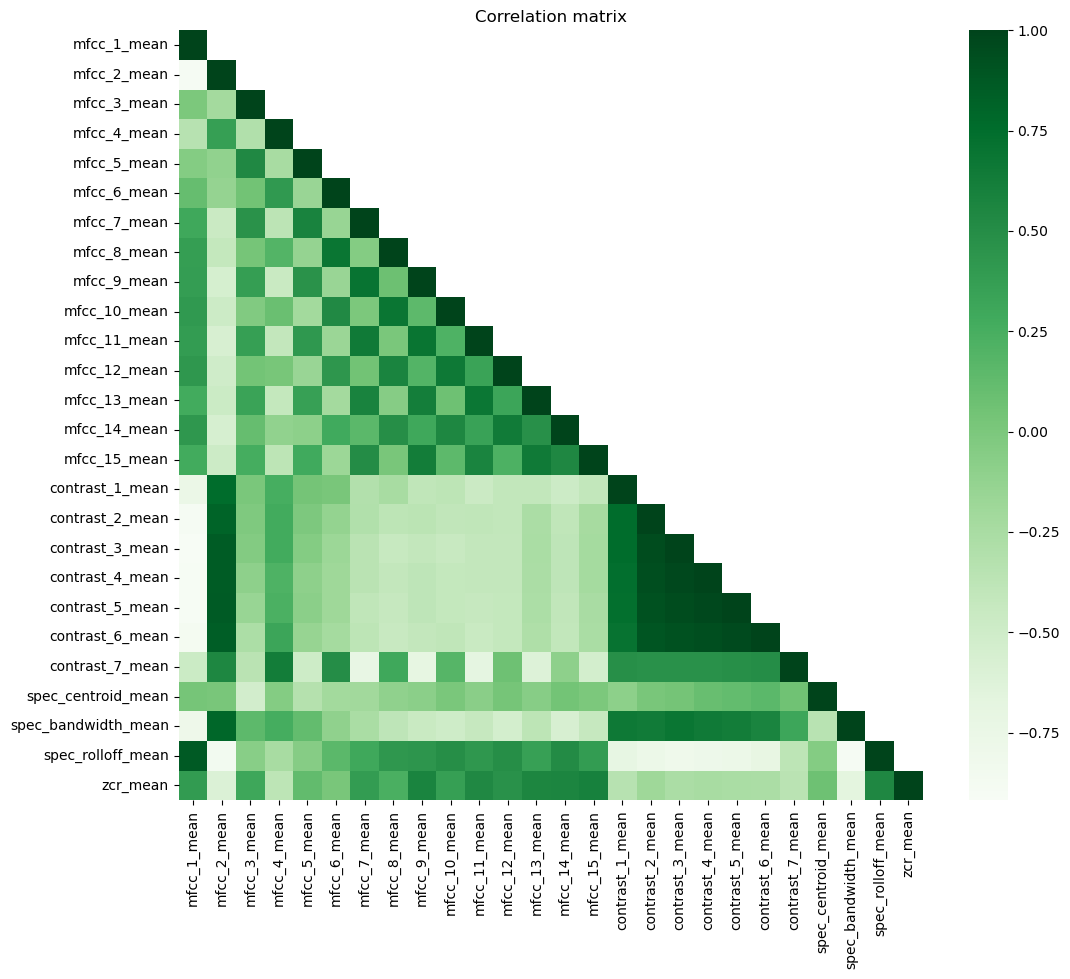

In [56]:
# Highly correlated features that can cause redundance
# zcr is highly correlated to rms, and both are highly correlated to all chroma values, so only zcr remains

cols_to_drop = [col for col in df.columns if ('chroma' in col) or ('rms' in col)]
df = df.drop(columns=cols_to_drop)

# New correlation matrix

mean_cols = [col for col in df.columns if 'mean' in col]
df_mean = df[mean_cols]

corr_mean = df_mean.corr()
corr_mean_lower = corr_mean.where(np.tril(np.ones(corr_mean.shape), k=0).astype(bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_mean_lower, cmap='Greens', annot=False, cbar=True)
plt.title("Correlation matrix")
plt.show()

### "std" features

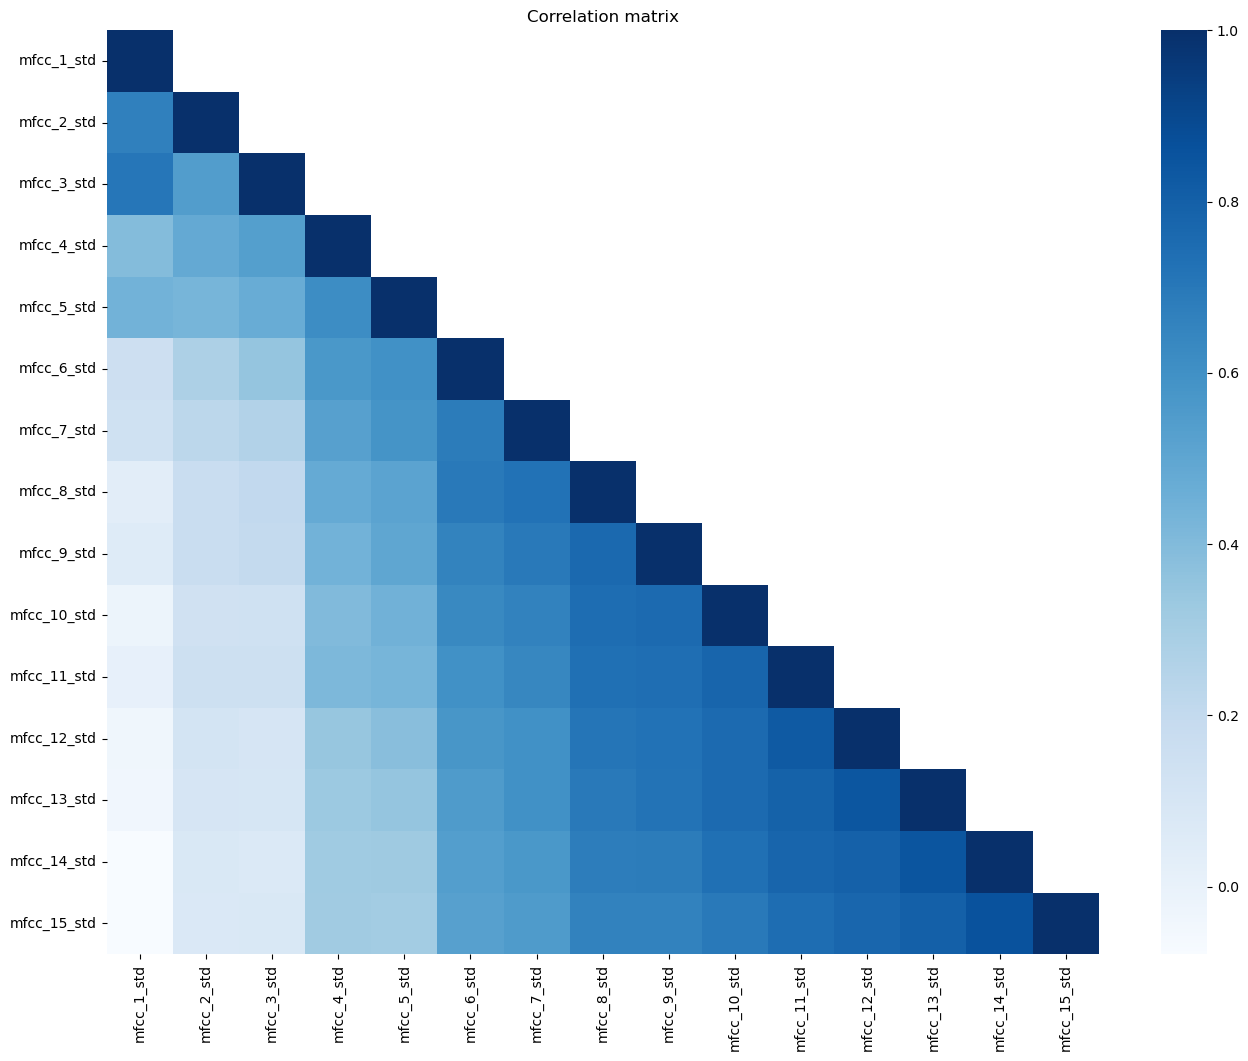

In [57]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr_std_lower, cmap='Blues', annot=False)
plt.title("Correlation matrix")
plt.show()

In [58]:
# "std" features pairs with high correlation
threshold = 0.98

high_corr_pairs = corr_std_lower.stack()
high_corr_pairs = high_corr_pairs[(high_corr_pairs > threshold) & (high_corr_pairs < 1.0)]
high_corr_pairs = high_corr_pairs.sort_values(ascending=False)

pd.set_option('display.max_rows', None)
print(high_corr_pairs.reset_index().rename(columns={0:'correlation'}))

Empty DataFrame
Columns: [level_0, level_1, correlation]
Index: []


In [59]:
print(df.columns)

Index(['mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean',
       'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std',
       'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean',
       'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean',
       'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean',
       'mfcc_12_std', 'mfcc_13_mean', 'mfcc_13_std', 'mfcc_14_mean',
       'mfcc_14_std', 'mfcc_15_mean', 'mfcc_15_std', 'contrast_1_mean',
       'contrast_2_mean', 'contrast_3_mean', 'contrast_4_mean',
       'contrast_5_mean', 'contrast_6_mean', 'contrast_7_mean',
       'spec_centroid_mean', 'spec_bandwidth_mean', 'spec_rolloff_mean',
       'zcr_mean', 'tempo', 'genre'],
      dtype='object')


## Random Forest

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [68]:
features = df.drop(columns=['genre'])  
labels = df['genre']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=y, random_state=42)

In [73]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [1000, 2000],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy'
)

# Train model with grid search
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Evaluate model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}
              precision    recall  f1-score   support

       blues       0.80      0.84      0.82       200
   classical       0.87      0.94      0.90       200
     country       0.77      0.73      0.75       199
       disco       0.79      0.80      0.79       200
      hiphop       0.86      0.84      0.85       200
        jazz       0.80      0.82      0.81       200
       metal       0.88      0.95      0.91       200
         pop       0.88      0.88      0.88       200
      reggae       0.74      0.78      0.76       200
        rock       0.85      0.65      0.73       200

    accuracy                           0.82      1999
   macro avg       0.82      0.82      0.82      1999
weighted avg       0.82      0.82      0.82      1999



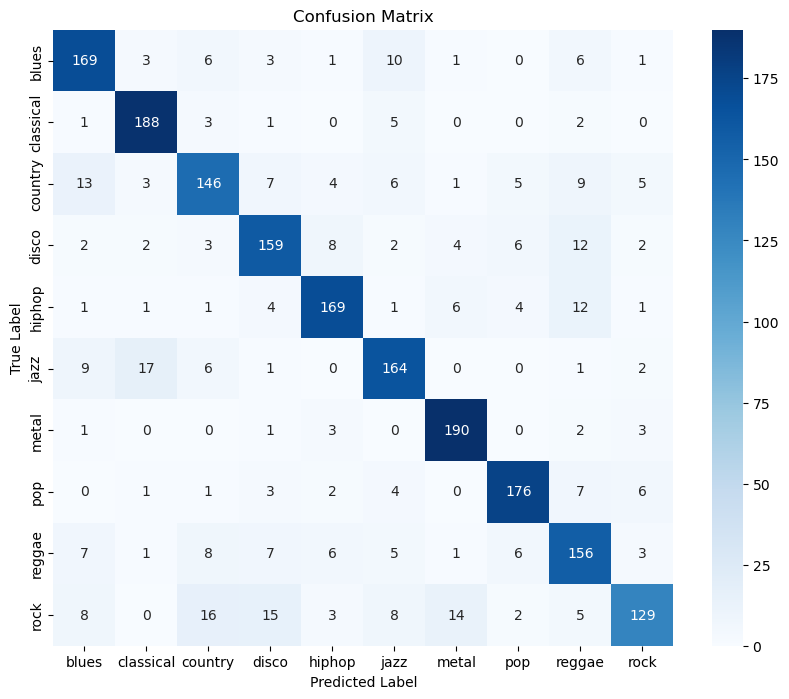

In [74]:
# Confusion matrix to better analyze results

cm = confusion_matrix(y_test, y_pred)

class_names = sorted(y_test.unique())

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

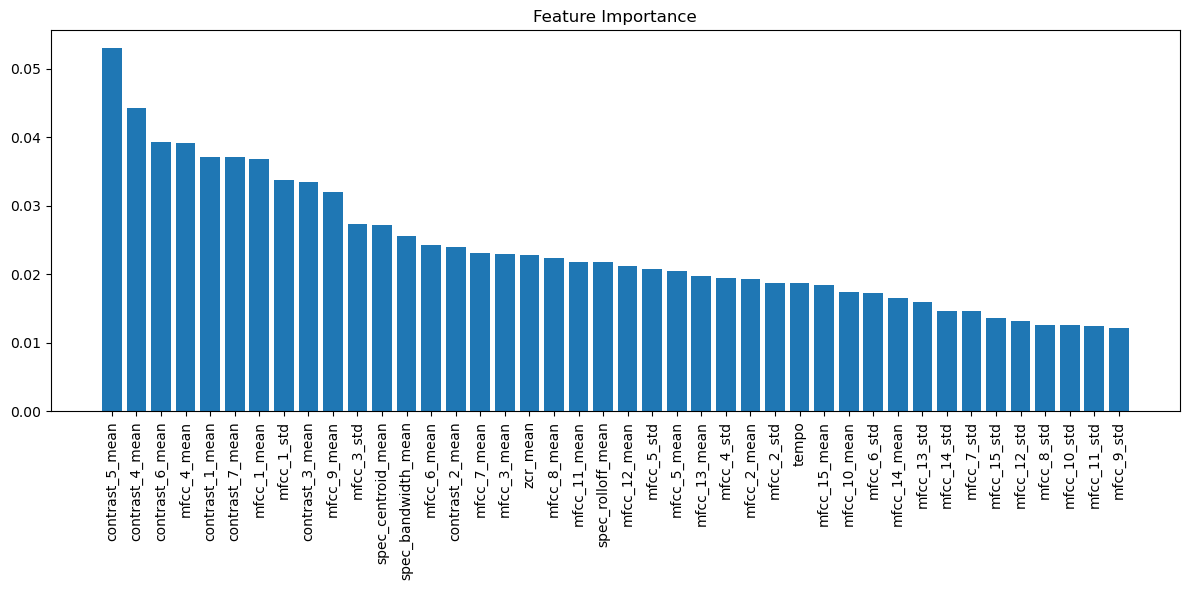

In [75]:
# Feature Importance

importances = best_rf.feature_importances_

feature_names = X_train.columns 

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()